# NN draw

In [7]:
import jax
import numpy as np
from time import time
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from jaxopt import ProjectedGradient

In [8]:
from bayesopt import test_functions, eval_fn, agents
from rebayes_mini.methods import low_rank_last_layer as lrll

/home/gerardoduran/miniconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/gerardoduran/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [10]:
# plt.rc("text", usetex=True)
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)
colors = sns.color_palette()

In [11]:
def plot_hist(ax, runs, color=None, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    color_plot = "black" if color is None else color
    color_fill = "tab:gray" if color is None else color
    
    ax.plot(med_run, c=color_plot, **kwargs)
    ax.fill_between(steps, lbound, ubound, color=color_fill, alpha=0.3)

# Setup

In [12]:
key = jax.random.PRNGKey(3141)
key_init, key_run = jax.random.split(key)

In [13]:
n_runs = 10
keys = jax.random.split(key_run, n_runs)

In [44]:
n_steps = 600
dim = 200
query_method = "grad"
exploration_method = "expected_improvement"

In [45]:
rank = 50
X_init = jnp.ones((1, dim))
objective_fn = test_functions.init_fn_draw_nn(key_init, dim)

In [46]:
lbound, ubound = 0.0, 1.0
n_warmup = dim

# Fifo Laplace

In [47]:
%%time
agent, bel_init_fn = agents.load_ll_laplace_agent(
    X_init, learning_rate=1e-4, buffer_size=10, n_inner=50,
    noise=0.1
)

time_init = time()
runs_laplace_diag = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, n_warmup, query_method,
    exploration_method
)
runs_laplace_diag = jax.tree.map(np.array, runs_laplace_diag)
time_laplace = time() - time_init

CPU times: user 10.1 s, sys: 333 ms, total: 10.4 s
Wall time: 21 s


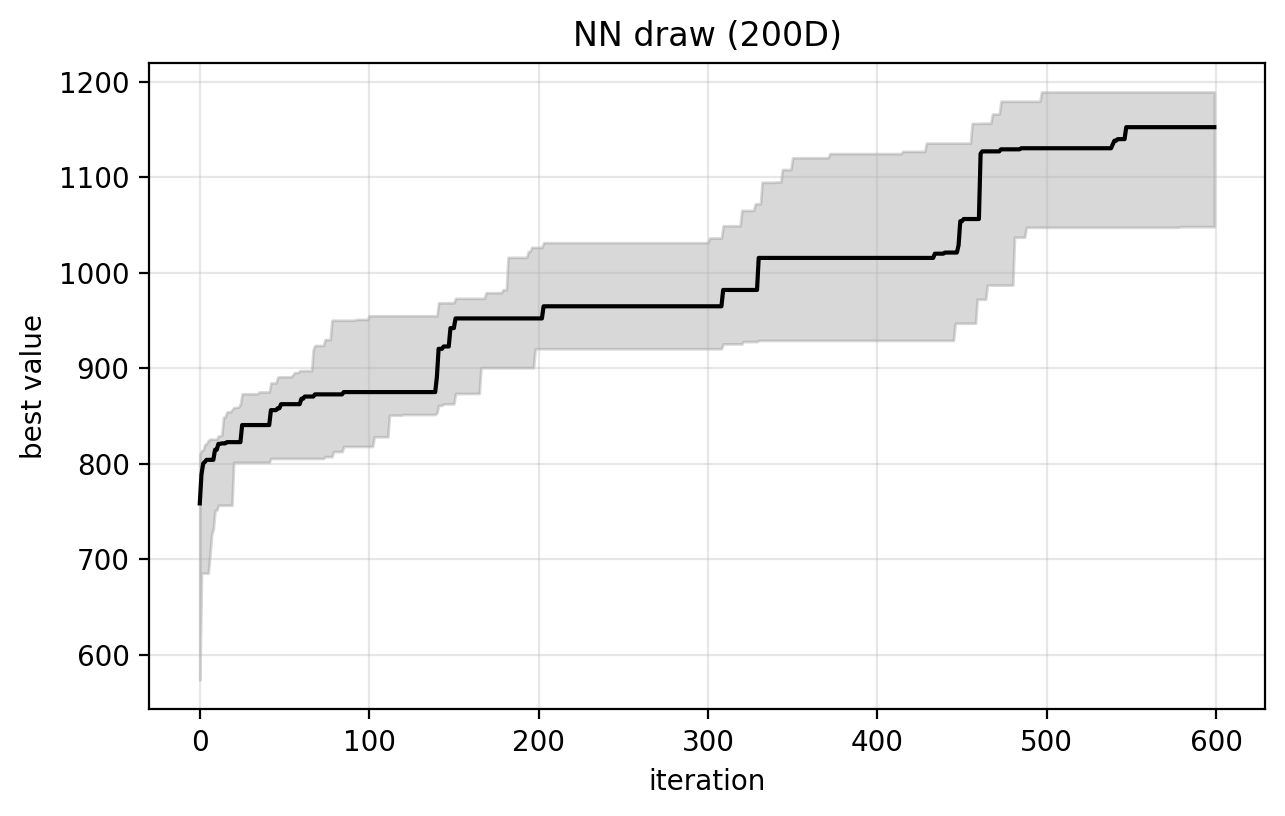

In [48]:
fig, ax = plt.subplots()
plot_hist(ax, runs_laplace_diag["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## LL-LRKF: FLoRES

In [49]:
agent, bel_init_fn = agents.load_ll_lrkf_agent(
    X_init, rank=rank, cov_hidden=1e-4, cov_last=1.0, low_rank_diag=True,
    dynamics_last=0.0, dynamics_hidden=0.0, obs_noise=0.0
)

In [50]:
%%time
time_init = time()
runs_flores = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, n_warmup,
    query_method, exploration_method
)
runs_flores = jax.tree.map(np.array, runs_flores)
time_flores = time() - time_init

CPU times: user 40.5 s, sys: 899 ms, total: 41.4 s
Wall time: 50.9 s


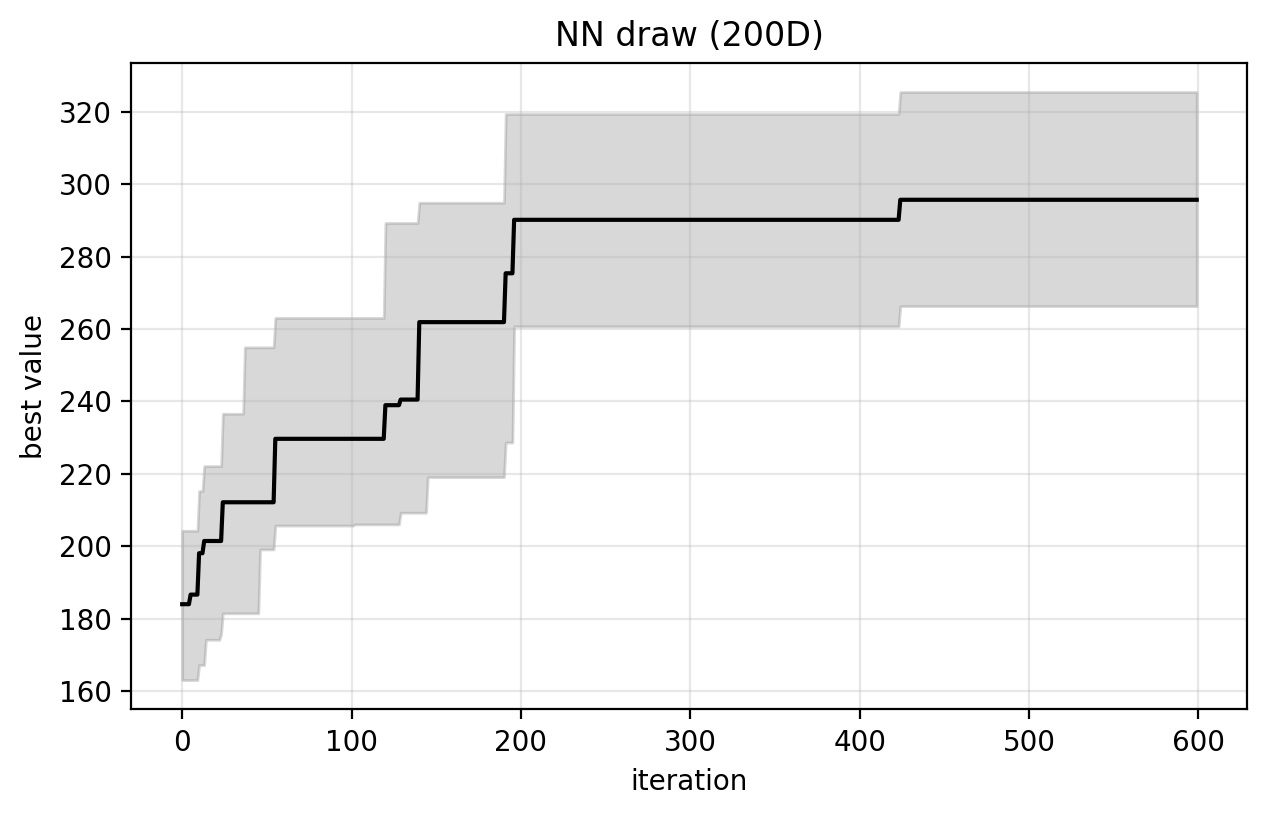

In [51]:
fig, ax = plt.subplots()
plot_hist(ax, runs_flores["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

# LRKF

In [52]:
agent, bel_init_fn = agents.load_lrkf_agent(
    X_init, rank=rank, cov=1.0, obs_noise=0.0, dynamics_cov=1e-6, low_rank_diag=False,
)

In [53]:
%%time
time_init = time()
runs_lrkf = eval_fn.test_runs(
    keys[:2], n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, n_warmup,
    query_method, exploration_method
)
runs_lrkf = jax.tree.map(np.array, runs_lrkf)
time_lrkf = time() - time_init

CPU times: user 21.7 s, sys: 372 ms, total: 22.1 s
Wall time: 41.2 s


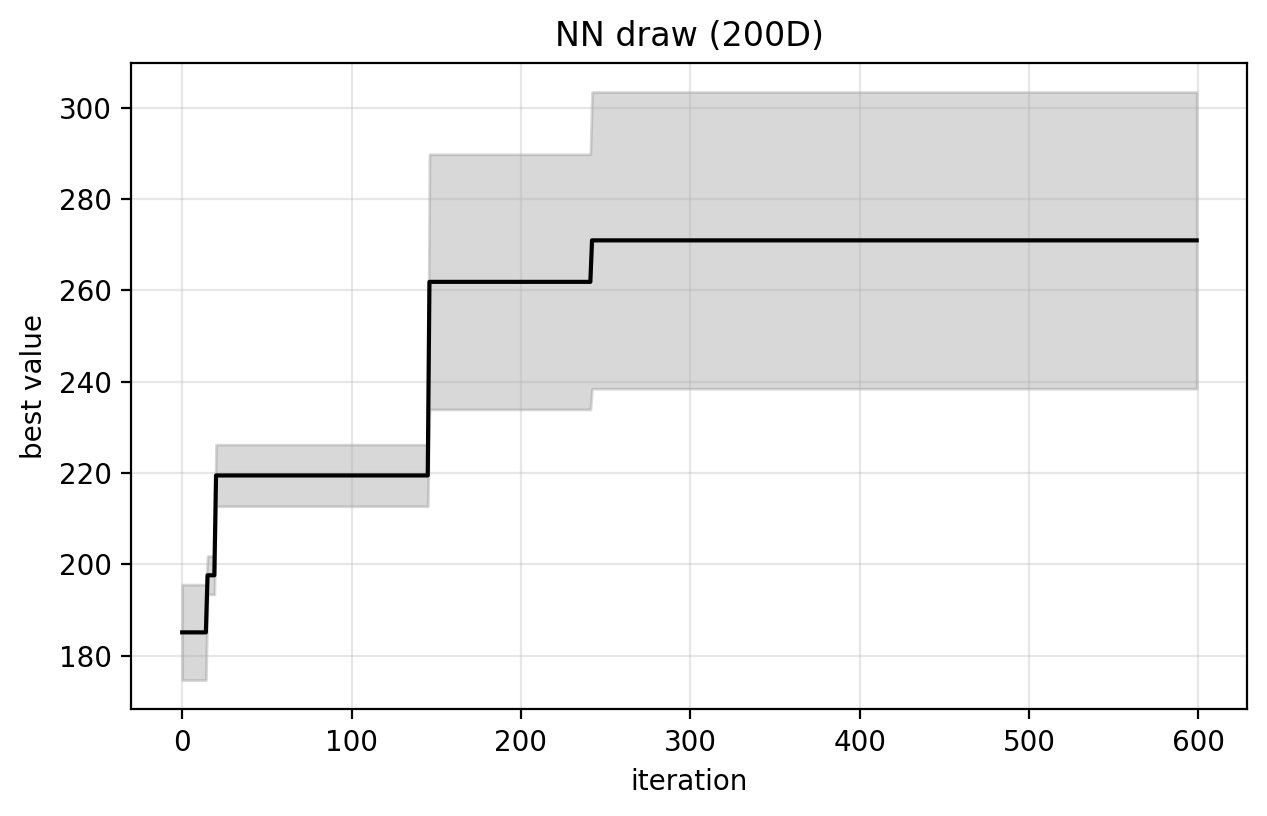

In [54]:
fig, ax = plt.subplots()
plot_hist(ax, runs_lrkf["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## VBLL

In [55]:
agent, bel_init_fn = agents.load_fifo_vbll_agent(
    X_init, learning_rate=1e-4, buffer_size=100, n_inner=100,
    wishart_scale=0.01, regularization_weight=0.1
)

In [56]:
%%time
time_init = time()
runs_vbll_full = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim, query_method,
    exploration_method
)
runs_vbll_full = jax.tree.map(np.array, runs_vbll_full)
time_vbll_full = time() - time_init

CPU times: user 15.2 s, sys: 498 ms, total: 15.7 s
Wall time: 16.9 s


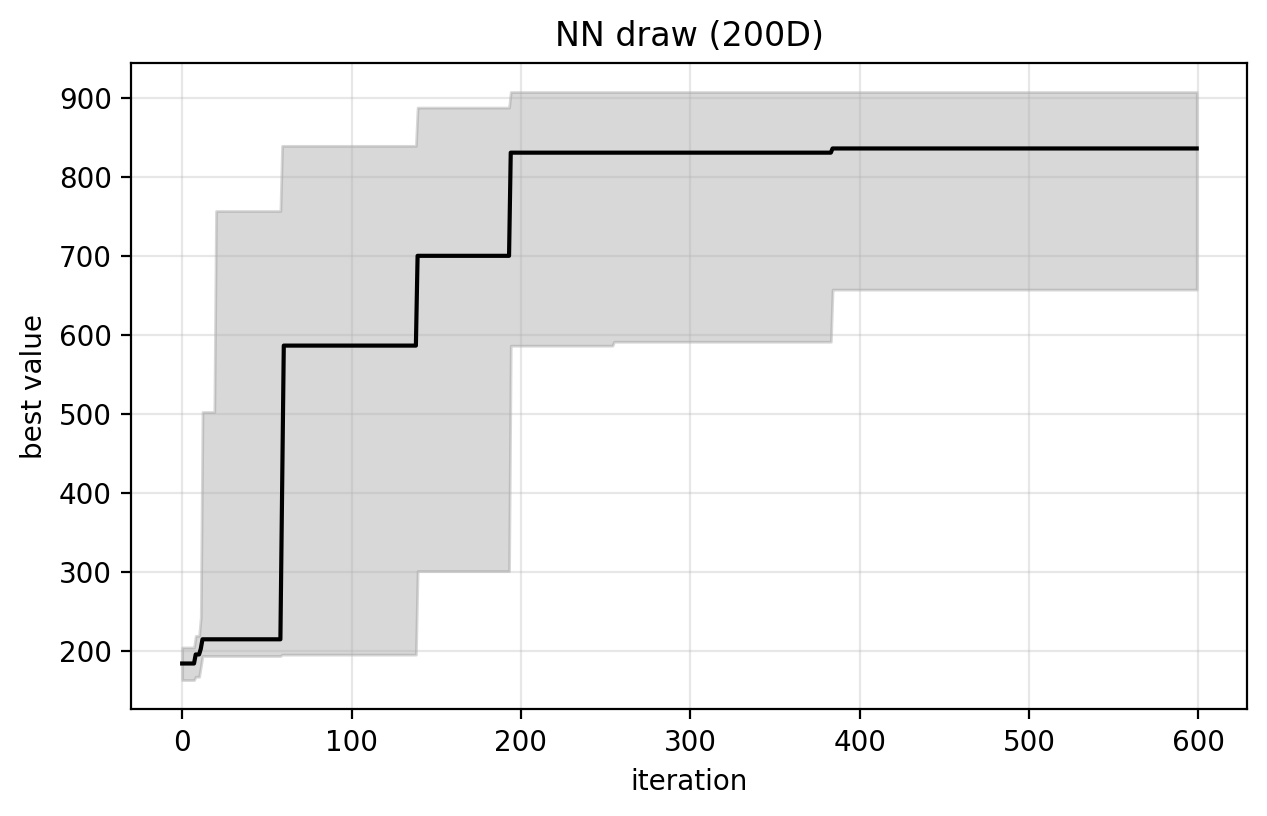

In [57]:
fig, ax = plt.subplots()
plot_hist(ax, runs_vbll_full["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## on-VBLL

In [58]:
agent, bel_init_fn = agents.load_fifo_vbll_agent(
    X_init, learning_rate=1e-4, buffer_size=10, n_inner=rank,
    wishart_scale=0.1, regularization_weight=0.0
)

In [59]:
%%time
time_init = time()
runs_vbll = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim,
    query_method, exploration_method
)
runs_vbll = jax.tree.map(np.array, runs_vbll)
time_vbll = time() - time_init

CPU times: user 12.6 s, sys: 319 ms, total: 12.9 s
Wall time: 10.8 s


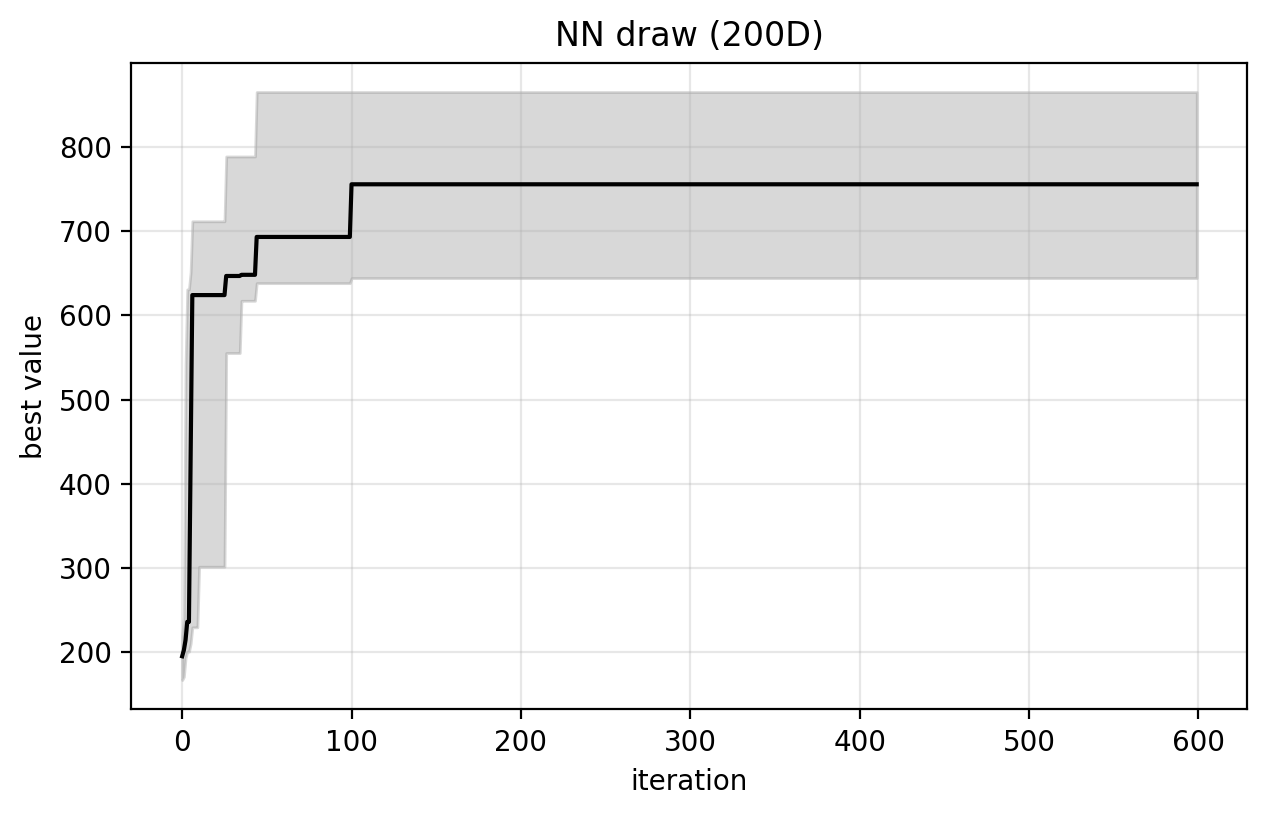

In [60]:
fig, ax = plt.subplots()
plot_hist(ax, runs_vbll["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## LoFi

In [61]:
rank = rank
agent, bel_init_fn = agents.load_lofi_agent(
    X_init, rank=rank, cov_init=1e-6, obs_noise=2.0, dynamics_covariance=1e-6
)

In [62]:
%%time
time_init = time()
runs_lofi = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim,
    query_method, exploration_method,
)
runs_lofi = jax.tree.map(np.array, runs_lofi)
time_lofi = time() - time_init

CPU times: user 53.5 s, sys: 2.8 s, total: 56.3 s
Wall time: 17.8 s


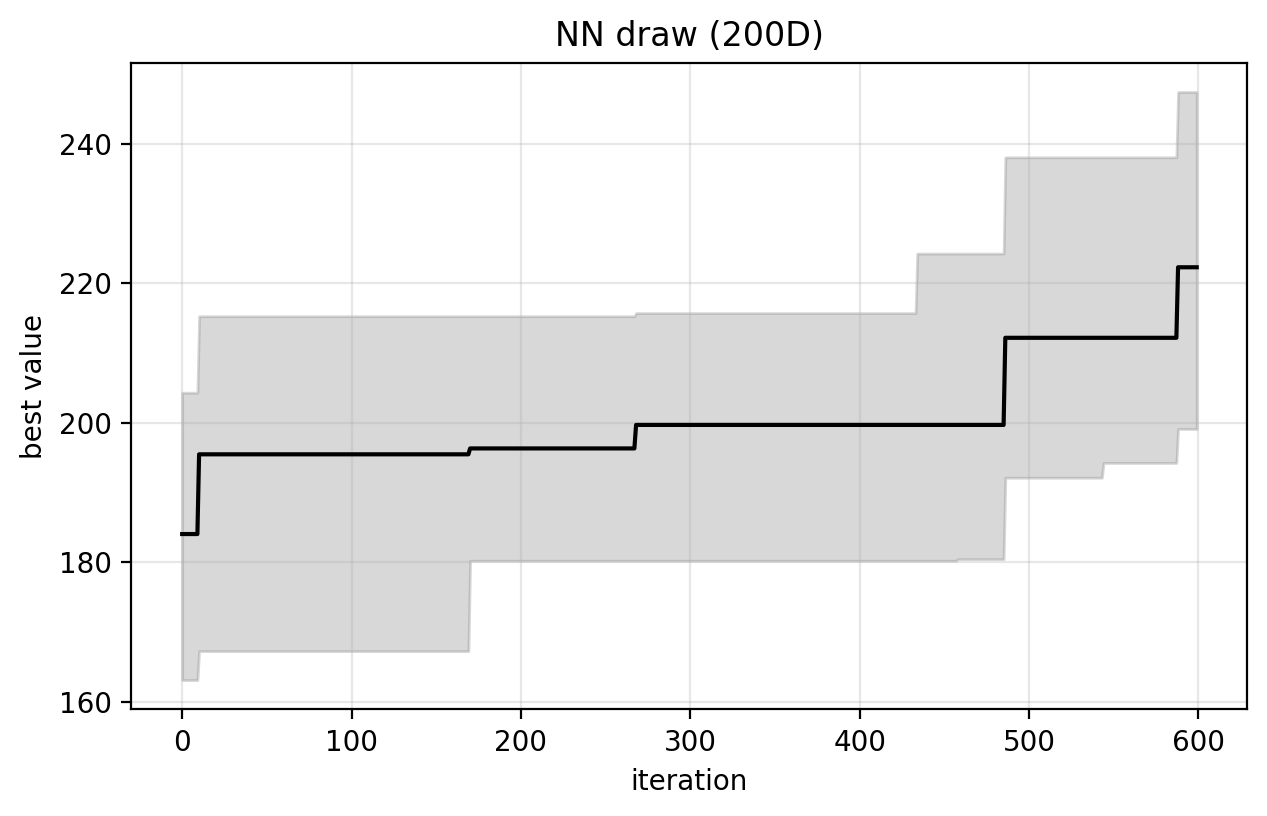

In [63]:
fig, ax = plt.subplots()
plot_hist(ax, runs_lofi["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

# Comparison

In [64]:
colors = sns.color_palette("colorblind", n_colors=6)
colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451)]

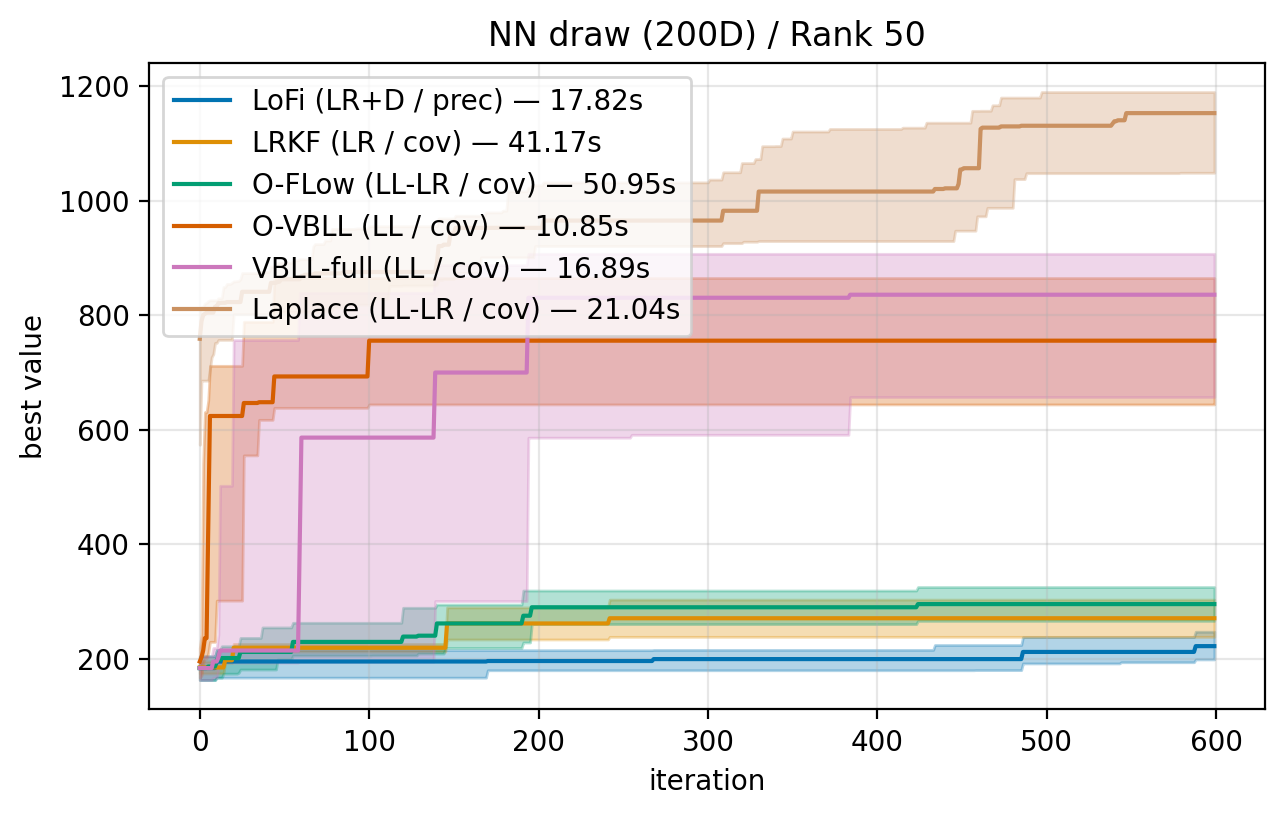

In [65]:
fig, ax = plt.subplots()
plot_hist(ax, runs_lofi["y_best"], label=f"LoFi (LR+D / prec) — {time_lofi:0.2f}s", color=colors[0])
plot_hist(ax, runs_lrkf["y_best"], label=f"LRKF (LR / cov) — {time_lrkf:0.2f}s",  color=colors[1])
plot_hist(ax, runs_flores["y_best"], label=f"O-FLow (LL-LR / cov) — {time_flores:0.2f}s",  color=colors[2])
plot_hist(ax, runs_vbll["y_best"], label=f"O-VBLL (LL / cov) — {time_vbll:0.2f}s",  color=colors[3])
plot_hist(ax, runs_vbll_full["y_best"], label=f"VBLL-full (LL / cov) — {time_vbll_full:0.2f}s",  color=colors[4])
plot_hist(ax, runs_laplace_diag["y_best"], label=f"Laplace (LL-LR / cov) — {time_laplace:0.2f}s",  color=colors[5])
# plot_hist(ax, runs_eflores["y_best"], label=f"en-O-FLow (LL-LR / cov) — {time_eflores:0.2f}s",  color=colors[5])
plt.title(f"NN draw ({dim}D) / Rank {rank}")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.legend()
plt.grid(alpha=0.3)
# plt.savefig(f"../figures/nn-draw-res-{dim}.png", dpi=300, bbox_inches="tight")

In [66]:
runs = {
    "VBLL-greedy": {**runs_vbll, "time": time_vbll},
    "VBLL": {**runs_vbll_full, "time": time_vbll_full},
    "FLoRES": {**runs_flores, "time": time_flores},
    "LRKF": {**runs_lrkf, "time": time_lrkf},
    "LOFI": {**runs_lofi, "time": time_lofi},
    "laplace": {**runs_laplace_diag, "time": time_laplace}
}

runs = jax.tree.map(np.array, runs)

In [68]:
import pickle
fn_string = f"nndraw{dim}"
with open(f"{fn_string}_{exploration_method}.pkl", "wb") as f:
    pickle.dump(runs, f)

## Run multiple dims

In [90]:
%%time
ranks = [1, 10, 20, 50, 100, 150]
n_steps = 600
n_runs = 20
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)

runs_all = {}
times_all = {}
for rank in ranks:
    print(rank, end="\r")

    time_init = time()
    agent, bel_init_fn = agents.load_ll_lrkf_agent(
        X_init, rank=rank, cov_hidden=1e-4, cov_last=0.01, dynamics_last=0.0, 
    )
    
    runs = eval_fn.test_runs(keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim, query_method)
    runs = jax.tree.map(np.array, runs)
    
    runs_all[rank] = runs
    times_all[rank] = time() - time_init

1

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()

colors = plt.cm.viridis(np.linspace(0, 1, len(ranks)))
for color, rank in zip(colors, ranks):
    plot_hist(ax, runs_all[rank]["y_best"], color=color, label=rank)
plt.legend(title="Rank", ncols=2)
# plt.ylim(bottom=800)
plt.xlim(left=0.0, right=n_steps)
plt.title("NN Draw — LL-LRKF")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)

## Run multiple noise terms

In [ ]:
%%time
# obs_noise = [0.0, 1e-7, 5e-7, 1e-6]
obs_noise = [0.0, 1e-6]
rank = 20
n_steps = 600
n_runs = 20
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)

runs_all = {}
for cfg in obs_noise:
    print(cfg, end="\r")
    
    agent, bel_init_fn = agents.load_ll_lrkf_agent(
        X_init, rank=rank, cov_hidden=1e-1, cov_last=0.1, obs_noise=cfg
    )    

    runs = eval_fn.test_runs(keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim, query_method)
    runs = jax.tree.map(np.array, runs)
    runs_all[cfg] = runs

In [ ]:
fig, ax = plt.subplots()

colors = plt.cm.viridis(np.linspace(0, 1, len(obs_noise)))
for color, cfg in zip(colors, obs_noise):
    plot_hist(ax, runs_all[cfg]["y_best"], color=color, label=cfg)
plt.legend(title="Rank", ncols=2)
plt.xlim(left=0.0, right=n_steps)
plt.title("NN Draw — LL-LRKF")
plt.grid(alpha=0.3)

## LoFi - no dynamics / low rank only

In [ ]:
rank = 50
agent, bel_init_fn = agents.load_lofi_agent(
    X_init, rank=rank, cov_init=1e-7, obs_noise=1.0, dynamics_covariance=0.0
)

In [ ]:
%%time
n_steps = 600
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
bel, runs_lrkf = eval_fn.test_run(
    key, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim
)
runs_lrkf = jax.tree.map(np.array, runs_lrkf)

In [ ]:
fig, ax = plt.subplots()
ax.plot(runs_lrkf["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

In [ ]:
%%time
time_init = time()
n_steps = 600
n_runs = 10
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
runs_lofi_null = eval_fn.test_runs(keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim)
runs_lofi_null = jax.tree.map(np.array, runs_lofi_null)
time_lofi_null = time() - time_init

In [ ]:
fig, ax = plt.subplots()
plot_hist(ax, runs_lofi_null["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

* LRKF sucks but its fast
* LoFi works much better, but it's slow
* LL-LRKF has comparable speed to LRKF, but its the top performing method

## LRKF 

In [ ]:
%%time
ranks = [1, 10, 50, 100, 150, 200, 300]

n_steps = 600
n_runs = 10
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)

runs_all = {}
times_all = {}

for rank in ranks:
    print(rank, end="\r")
    agent, bel_init_fn = agents.load_lrkf_agent(
        X_init, rank=rank, cov=2.0, obs_noise=0.0, dynamics_cov=1.0, low_rank_diag=False,
    )
    time_init = time()
    
    runs_lrkf = eval_fn.test_runs(
        keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim, query_method
    )
    runs_lrkf = jax.tree.map(np.array, runs_lrkf)
    time_lrkf = time() - time_init
    
    runs_all[rank] = runs_lrkf
    times_all[rank] = time_lrkf

In [ ]:
fig, ax = plt.subplots()

colors = plt.cm.viridis(np.linspace(0, 1, len(ranks)))
for color, rank, in zip(colors, ranks):
    seconds = times_all[rank]
    plot_hist(ax, runs_all[rank]["y_best"], color=color, label=f"{rank:03} — {seconds:0.2f}s")
# plot_hist(ax, runs_lofi["y_best"], label=f"LoFi(50) — {time_lofi:0.2f}s", color="black")
plt.legend(title="Rank", ncols=1, bbox_to_anchor=(1,1), frameon=False)
# plt.ylim(bottom=800)
plt.xlim(left=0.0, right=n_steps)
plt.title("NN Draw — LRKF")
plt.grid(alpha=0.3)